In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style()
import pandas as pd

# import dysts
from dysts.datasets import *
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

import degas.degas.degas as dg
dg.set_style()

%matplotlib inline
%load_ext autoreload
%autoreload 2
is_even = False

# Tune hyperparameters

In [52]:
%%bash

# python3 find_hyperparameters.py

Couldn't find program: 'bash'


# Run and record forecasts on test data

In [73]:
%%bash --out output --err error

# python3 compute_benchmarks.py

Process is terminated.


## Load Forecasting Benchmark Results

# Run the following twice, once with 15 and once with 100 GRANULARITY
# To recreate the other plots, set the respective results_ending

In [70]:
import os
import json

# TODO: run this twice
GRANULARITY = 100 if is_even else 15
print(f"{is_even} Granularity {GRANULARITY}")
is_even = not is_even
#results_ending = "_esn_ESN_torch"
results_ending = "_RNNModel_ALL"
#results_ending = "_esn_ALL"
# TODO: all comparison for appendix
skip_dyn_systems = ["PiecewiseCircuit", "AtmosphericRegime"]
path = "../plots"
os.makedirs(path, exist_ok=True)

if results_ending == "_esn_ESN_torch":
    model_columns = ['values',
                     'LinearRegressionModel',
                     'ExponentialSmoothing',
                     'esn_ESN_torch']
    model_columns_renamed = ['values',
                             'Lin. Regression',
                             'Exp. Smoothing',
                             'ESN_torch']
    violin_path = ""
    drop_not_renamed = False
elif results_ending == "_esn_ALL":
    model_columns = ['values',
                     'esn_LSTM',
                     'esn_GRU',
                     'esn_RNN',
                     'esn_ESN_torch']
    model_columns_renamed = ['values',
                             'esn_LSTM',
                             'esn_GRU',
                             'esn_RNN',
                             'ESN_torch']
    violin_path = "_esn"
    drop_not_renamed = True
elif results_ending == "_RNNModel_ALL":
    model_columns = ['values',
                     'RNNModel',
                     'RNNModel_GRU',
                     'RNNModel_RNN',
                     'esn_ESN_torch']
    model_columns_renamed = ['values',
                             'LSTM',
                             'GRU',
                             'RNN',
                             'ESN_torch']
    violin_path = "_RNNModel"
    drop_not_renamed = True

with open(
    os.getcwd()
    + "/results/results_test_univariate__pts_per_period_" + str(GRANULARITY) 
    + "__periods_12"
    + results_ending
    + ".json",
    "r",
) as file:
    all_results = json.load(file)


# Skip systems
for dyn_syst in skip_dyn_systems:
    all_results.pop(dyn_syst, None)

# Only selected models
if model_columns is not None:
    for dyn_syst in all_results:
        if drop_not_renamed:
            all_results[dyn_syst] = {
                new: all_results[dyn_syst][old] for new, old in zip(model_columns_renamed, model_columns)
            }
        else:
            for new, old in zip(model_columns_renamed, model_columns):
                all_results[dyn_syst][new] = all_results[dyn_syst].pop(old, None)


# with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_15__periods_12_noise.json", "r") as file:
#     all_results = json.load(file)

## Convert R2 into a distance
all_r2 = list()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            ## convert r2 to a pseudodistance
            all_results[equation_name][model_name]["r2_score"] = (
                1 - all_results[equation_name][model_name]["r2_score"]
            )

            ## Coefficient of variation must be normed
            all_results[equation_name][model_name]["coefficient_of_variation"] = np.abs(
                all_results[equation_name][model_name]["coefficient_of_variation"]
            )

            ## Drop RMSE because it overlaps with MSE
            all_results[equation_name][model_name].pop("rmse", None)


from darts import TimeSeries
from darts.metrics import mae

wrap_array = lambda x: TimeSeries.from_dataframe(pd.DataFrame(np.squeeze(np.array(x))))
mae_func = lambda x, y: mae(wrap_array(x), wrap_array(y))


## Calculate MASE
for equation_name in all_results:
    baseline_onestep = mae_func(
        all_results[equation_name]["values"][1:],
        all_results[equation_name]["values"][:-1],
    )
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        else:
            mae_val = all_results[equation_name][model_name]["mae"]
            all_results[equation_name][model_name]["mase"] = mae_val / baseline_onestep

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])

all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][
            model_name
        ]


hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])

    hist_values[model_name] = smape_vals.copy()

if GRANULARITY == 15:
    hist_values_low = hist_values.copy()
elif GRANULARITY == 100:
    hist_values_high = hist_values.copy()
else:
    raise ValueError("Granularity must be 15 or 100 points per period.")

any_model = model_columns_renamed[1] if model_columns_renamed is not None else "ARIMA"
all_metric_names = list(all_results_transposed[any_model]["Aizawa"].keys())
all_metric_names.remove("prediction")

## Compute forecast metrics
metric_records = dict()
for metric_name in all_metric_names:
    metric_records[metric_name] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        for metric_name in all_metric_names:
            metric_records[metric_name].append(
                all_results_transposed[model_name][equation_name][metric_name]
            )
df_metrics = pd.DataFrame(metric_records)


# df_metrics["coefficient_of_variation"] = np.abs(df_metrics["coefficient_of_variation"])
# df_metrics = df_metrics.drop('rmse', 1)

True Granularity 100


['prediction',
 'coefficient_of_variation',
 'mae',
 'mape',
 'marre',
 'mse',
 'r2_score',
 'smape',
 'mase']

In [71]:
df_metrics


,coefficient_of_variation,mae,mape,marre,mse,r2_score,smape,mase
0,5260.353763,0.310931,368.793490,12.300961,0.149700,0.404607,80.294242,7.162145
1,1044.710740,1.545390,437.199975,29.284994,3.767991,1.869584,107.415282,17.432690
2,53.318714,0.782293,137.560014,20.084254,0.858748,0.743931,70.054567,16.887657
3,1051.580036,0.704825,422.681975,40.624309,0.697846,1.997858,132.363623,41.798337
4,22.064077,0.024595,20.315255,98.288296,0.000705,16.893023,23.034908,67.111473
...,...,...,...,...,...,...,...,...
515,5259.288833,16.320668,4074.828690,371.296711,313.777318,339.235279,183.054158,346.960649
516,14.306797,0.077204,10.458934,17.903791,0.013668,0.700722,9.574758,9.197755
517,516.880397,1.339955,307.574180,30.679695,3.045039,2.200022,124.503732,11.998248
518,158.907079,0.407145,90.115062,8.875877,0.221753,0.122705,62.711501,11.631061


### Load mathematical properties

In [72]:
import dysts.flows

max_lyap = list()
best_scores = list()
for equation_name in all_results:

    all_scores_per_equation = list()
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_scores_per_equation.append(all_results[equation_name][model_name]["smape"])
    
    best_scores.append(min(all_scores_per_equation))

    eq = getattr(dysts.flows, equation_name)()
    max_lyap.append(eq.maximum_lyapunov_estimated)
        


### Correlate forecasting models

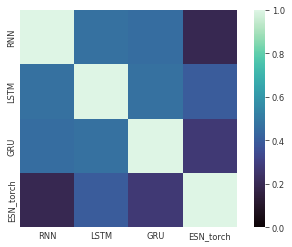

In [73]:
model_records = dict()
for model_name in all_results_transposed.keys():
    model_records[model_name ] = list()
for model_name in all_results_transposed:
    for equation_name in all_results_transposed[model_name]:
        model_records[model_name].append(all_results_transposed[model_name][equation_name]["smape"])
df_models = pd.DataFrame(model_records)


corr_array = np.array(df_models.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

df_models_sorted = df_models.iloc[:, np.argsort(np.nanmedian(corr_array, axis=0))[::-1]]
df_models_sorted = df_models.iloc[:, np.argsort(np.nanmax(corr_array, axis=0))[::-1]]

# df_models_sorted = df_models.iloc[:, sort_order]

ax = sns.heatmap(df_models_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

dg.better_savefig(f"{path}/model_correlation_map.pdf")#, dpi=600)

### Compare forecasting metrics

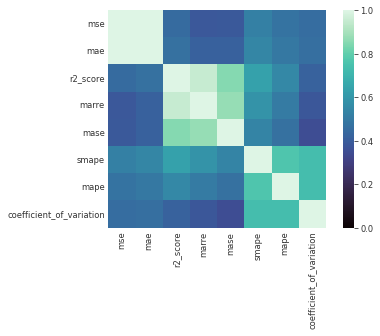

In [74]:

corr_array = np.array(df_metrics.corr(method='spearman'))
np.fill_diagonal(corr_array, np.nan)

metric_sort_inds = np.argsort(np.nanmedian(corr_array, axis=0))[::-1]
metric_sort_inds = np.argsort(np.nanmax(corr_array, axis=0))[::-1]
df_metrics_sorted = df_metrics.iloc[:, metric_sort_inds]


ax = sns.heatmap(df_metrics_sorted.corr(method='spearman'), cmap="mako", vmin=0, vmax=1)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', length=0)

dg.better_savefig(f"{path}/metric_map.pdf")#, dpi=600)

### Compare forecasting results against mathematical properties

In [75]:
chosen_metric = "smape"
models_df = dict()
metrics_df = dict()
for equation_name in all_results:
    models_df[equation_name] = dict()
    metrics_df[equation_name] = dict()
    for model_name in all_results[equation_name]:
        if model_name == "values": continue
        models_df[equation_name][model_name] = all_results[equation_name][model_name][chosen_metric]
    
        for metric_name in all_metric_names:
            if metric_name == "prediction": continue
            metrics_df[equation_name][metric_name] = all_results[equation_name]["ESN_torch"][metric_name]
    
    
models_df = pd.DataFrame(models_df).transpose()
metrics_df = pd.DataFrame(metrics_df).transpose()

In [76]:
import dysts.flows

attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in get_attractor_list():
    if equation_name in skip_dyn_systems:
        continue
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
all_properties = pd.DataFrame(all_properties).transpose().dropna()

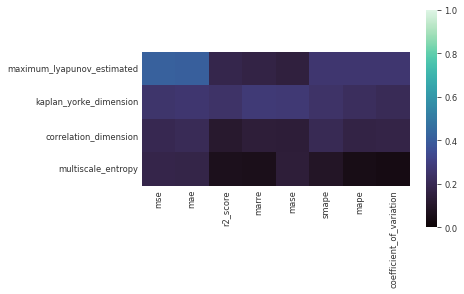

In [77]:
cross_corr = pd.concat([metrics_df, all_properties], axis=1, keys=['metrics_df', 'all_properties']).corr(method="spearman").loc['metrics_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds, metric_sort_inds], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

dg.better_savefig(f"{path}/metric_math.pdf")#, dpi=600)

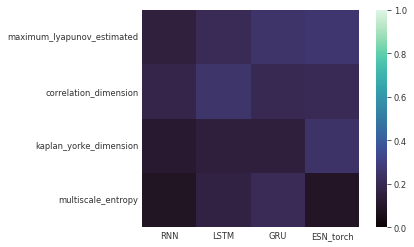

In [78]:
cross_corr = pd.concat([models_df, all_properties], axis=1, keys=['models_df', 'all_properties']).corr(method="spearman").loc['models_df', 'all_properties']
math_sort_inds = np.argsort(np.max(cross_corr, axis=0))[::-1]

ax = sns.heatmap(cross_corr.transpose().iloc[math_sort_inds][df_models_sorted.columns], cmap="mako", vmin=0, vmax=1)
ax.set_aspect(1)
ax.tick_params(axis='both', which='both', length=0)

dg.better_savefig(f"{path}/models_math_corr.pdf")#, dpi=600)

In [79]:

## Easiest and hardest systems
print("Easiest systems: ", np.unique(models_df.idxmin(axis=0), return_counts=True))
print("Hardest systems: ", np.unique(models_df.idxmax(axis=0), return_counts=True))


all_median_names = list()
for key in models_df.keys():
    all_median_names.append(models_df[models_df[key] == models_df[key].quantile(interpolation='nearest')].index[0])
    
print("Middle systems: ", np.unique(all_median_names, return_counts=True))

Easiest systems:  (array(['Torus'], dtype=object), array([4], dtype=int64))
Hardest systems:  (array(['LiuChen', 'SprottTorus', 'TurchinHanski', 'ZhouChen'],
      dtype=object), array([1, 1, 1, 1], dtype=int64))
Middle systems:  (array(['ItikBanksTumor', 'Lorenz', 'Sakarya', 'SprottI'], dtype='<U14'), array([1, 1, 1, 1], dtype=int64))


C:\Users\blend\Desktop\Fatjon\reservoir_computing\dysts\base.py:288: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  "This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system."


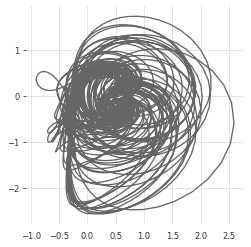

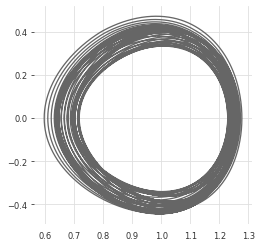

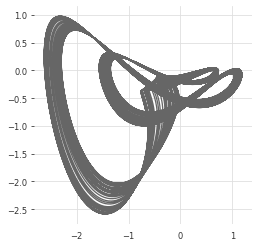

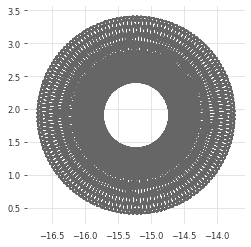

In [80]:
from dysts.flows import SprottTorus, StickSlipOscillator, Torus, SprottG

style1 = {"color": (0.4, 0.4, 0.4)}

plt.figure()
sol = SprottTorus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
#dg.vanish_axes()
dg.better_savefig(f"{path}/sprott_torus.pdf")#, dpi=600)



plt.figure()
sol = StickSlipOscillator().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
#dg.vanish_axes()
dg.better_savefig(f"{path}/stickslip.pdf")#, dpi=600)



plt.figure()
sol = SprottG().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
#dg.vanish_axes()
dg.better_savefig(f"{path}/sprottg.pdf")#, dpi=600)

plt.figure()
sol = Torus().make_trajectory(50000, resample=True, pts_per_period=400)
plt.plot(sol[:, 0], sol[:, 1], **style1)
dg.fixed_aspect_ratio(1)
#dg.vanish_axes()
dg.better_savefig(f"{path}/torus.pdf")#, dpi=600)

### Compare different forecasting models

In [81]:
import pandas as pd

def mirror_df(df, mirror_val=0):
    """
    Create a mirrored augmented dataframe. Used
    for setting the right boundary conditions on kernel 
    density plots
    """
    if np.isscalar(mirror_val):
        return pd.concat([df, mirror_val - df])
    else:
        all_out_df = [df]
        for val in mirror_val:
            all_out_df.append(val - df)
        return pd.concat(all_out_df)
    
dflo = pd.DataFrame.from_dict(hist_values_low)
#dflo = dflo[model_columns]
#dflo.columns = model_columns_renamed
dflo["Granularity"] = "Coarse"

dfhi = pd.DataFrame.from_dict(hist_values_high)
#dfhi = dfhi[model_columns]
#dfhi.columns = model_columns_renamed
dfhi["Granularity"] = "Fine"
data = pd.merge(dflo, dfhi, how="outer")

all_model_names = np.array(list(hist_values_high.keys()))
all_medians = [np.median(hist_values_high[name]) for name in hist_values_high]
all_means = [np.mean(hist_values_high[name]) for name in hist_values_high]
sort_order = np.argsort(all_medians)

data_long = pd.melt(data, value_vars=all_model_names[sort_order], id_vars="Granularity")

RNNModel


ValueError: Length mismatch: Expected axis has 18 elements, new values have 2 elements

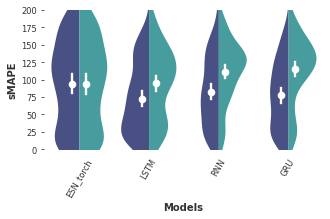

In [82]:
plot_width = 20/16 * len(all_results_transposed)
plt.figure(figsize=(plot_width, 10))
ax = plt.gca()


ax = sns.violinplot(
    data=data_long,
    x="variable",
    y="value",
    hue="Granularity",
    order=all_model_names[sort_order],
    linewidth=0,
    size=3,
    alpha=0.1,
    split=True,
    scale="area",
    inner=None,
    palette="mako",
)
ax = sns.pointplot(
    data=data_long,
    x="variable",
    y="value",
    hue="Granularity",
    order=all_model_names[sort_order],
    linewidth=0,
    size=4,
    palette={"Coarse": "w", "Fine": "w"},
    join=False,
    ci=99,
    dodge=0.2,
)


plt.ylim([0, 200])
dg.fixed_aspect_ratio((1 / 8) * 16 / len(all_results_transposed))
ax.grid(False)
ax.legend_.remove()
ax.tick_params(axis='x', rotation=60)
plt.xlabel("Models")
plt.ylabel("sMAPE")

dg.better_savefig(f"{path}/forecasting_violins{violin_path}.pdf")#, dpi=600)

## Group models by mathematical properties

In [103]:
import matplotlib.pyplot as plt

In [ ]:
equation_names = list(all_results.keys())
model_names = list(all_results[equation_names[0]].keys())
model_names.remove("values")
score_names = list(all_results[equation_names[0]][model_names[0]].keys())
score_names.remove("prediction")

results_reduced = dict()
for equation_name in equation_names:
    results_reduced[equation_name] = dict()
    for model_name in model_names:
        val = all_results[equation_name][model_name]["smape"]
        results_reduced[equation_name][model_name] = val 
results_reduced = pd.DataFrame.from_dict(results_reduced)     
results_reduced = results_reduced.iloc[sort_order] # sort by median error

In [ ]:
sort_inds = all_properties.sort_values(by="maximum_lyapunov_estimated").index

color_list = sns.color_palette("husl", results_reduced.shape[0])

plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.semilogx(
        all_properties["maximum_lyapunov_estimated"][sort_inds],
        row,
        color=clr
    )
plt.title("Score versus Lyapunov exponent")




sort_inds = all_properties.sort_values(by="correlation_dimension").index

plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr
    )
plt.title("Score versus correlation dimension")


plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr,
        linewidth=4
    )
plt.legend(results_reduced.index, facecolor='white', framealpha=1, frameon=True)
plt.title("Show legend")

In [ ]:
sort_inds
#results_reduced[sort_inds]

In [ ]:
prop_name = "correlation_dimension"
prop_name = "maximum_lyapunov_estimated"
prop_name = "multiscale_entropy"

all_vals = list()
vals = np.array(all_properties[prop_name])

all_windows = list(zip(10 * np.arange(9), 10 * np.arange(2, 11)))

for window in all_windows:
    sel_inds = all_properties[prop_name][
        all_properties[prop_name].between(
            np.percentile(vals, window[0]), np.percentile(vals, window[1])
        )
    ].index
    all_vals.append(results_reduced[sel_inds].median(axis=1))
    
plt.figure()
for clr, row in zip(color_list, np.array(all_vals).T):
    plt.plot(row, color=clr)
plt.ylim([0, 180])
dg.better_savefig(f"{path}/{prop_name}_ranks.pdf")#, dpi=600)

In [80]:

    
plt.figure()
for clr, row in zip(color_list, results_reduced[sort_inds].to_numpy()):
    plt.plot(
        all_properties["correlation_dimension"][sort_inds],
        row,
        color=clr,
        linewidth=4
     )
plt.legend(results_reduced.index, facecolor='white', framealpha=1, frameon=True)
plt.title("Show legend")

dg.better_savefig(f"{path}/lyap_legend.pdf")#, dpi=600)



NameError: name 'color_list' is not defined

<Figure size 432x288 with 0 Axes>